In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [4]:
class ModifiedMobileNetV2(nn.Module):
    def init(self, num_classes=10):
        super(ModifiedMobileNetV2, self).init()
        # Load pretrained MobileNetV2
        mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
        
        # Keep all layers except the classifier
        self.features = mobilenet.features
        
        # Freeze the feature layers
        for param in self.features.parameters():
            param.requires_grad = False
            
        # Create new classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1280, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes)
        )
                
    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNetV2 expects 224x224 images
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels before ToTensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

100%|██████████| 9.91M/9.91M [05:17<00:00, 31.2kB/s]
100%|██████████| 28.9k/28.9k [00:01<00:00, 15.0kB/s]
100%|██████████| 1.65M/1.65M [00:55<00:00, 29.6kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [7]:
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [9]:
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
class ModifiedMobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedMobileNetV2, self).__init__()
        # Load pretrained MobileNetV2
        mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
        
        # Keep all layers except the classifier
        self.features = mobilenet.features
        
        # Freeze the feature layers
        for param in self.features.parameters():
            param.requires_grad = False
            
        # Create new classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1280, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

model = ModifiedMobileNetV2(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

c:\Users\ACER\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ACER/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [03:36<00:00, 65.7kB/s]


In [14]:
def train_model():
    print("Starting training...")
    model.train()
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            # Images are already in RGB format (3 channels)
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Accuracy: {100 * correct / total:.2f}%')
        
        print(f'Epoch [{epoch+1}/{num_epochs}] completed. '
              f'Average Loss: {running_loss/total_step:.4f}, '
              f'Final Accuracy: {100 * correct / total:.2f}%')

In [15]:
def evaluate_model():
    print("\nEvaluating model on test set...")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Images are already in RGB format
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [16]:
train_model()

Starting training...
Epoch [1/10], Step [100/1875], Loss: 0.7278, Accuracy: 61.97%
Epoch [1/10], Step [200/1875], Loss: 0.4585, Accuracy: 73.69%
Epoch [1/10], Step [300/1875], Loss: 0.3373, Accuracy: 77.72%
Epoch [1/10], Step [400/1875], Loss: 0.3548, Accuracy: 80.49%
Epoch [1/10], Step [500/1875], Loss: 0.1844, Accuracy: 81.76%
Epoch [1/10], Step [600/1875], Loss: 0.2762, Accuracy: 82.96%
Epoch [1/10], Step [700/1875], Loss: 0.3861, Accuracy: 83.95%
Epoch [1/10], Step [800/1875], Loss: 0.2574, Accuracy: 84.80%
Epoch [1/10], Step [900/1875], Loss: 0.4473, Accuracy: 85.46%
Epoch [1/10], Step [1000/1875], Loss: 0.3195, Accuracy: 85.94%
Epoch [1/10], Step [1100/1875], Loss: 0.2141, Accuracy: 86.34%
Epoch [1/10], Step [1200/1875], Loss: 0.7929, Accuracy: 86.79%
Epoch [1/10], Step [1300/1875], Loss: 0.1354, Accuracy: 87.08%
Epoch [1/10], Step [1400/1875], Loss: 0.5957, Accuracy: 87.41%
Epoch [1/10], Step [1500/1875], Loss: 0.2639, Accuracy: 87.59%
Epoch [1/10], Step [1600/1875], Loss: 0.372

In [17]:
evaluate_model()


Evaluating model on test set...
Test Accuracy: 96.77%



Visualizing sample predictions...


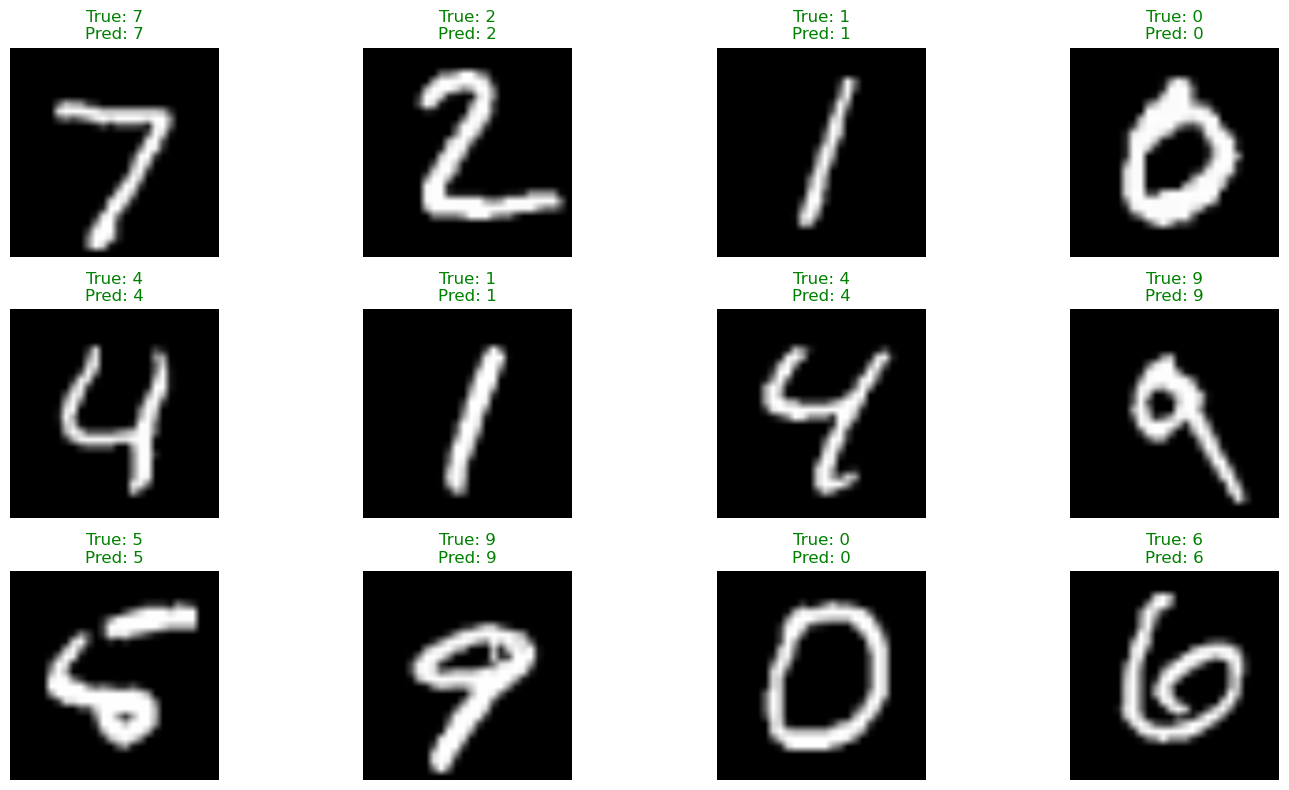

In [18]:
def visualize_predictions():
    print("\nVisualizing sample predictions...")
    
    # Set the model to evaluation mode
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Move to device and get predictions
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Move back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    
    # Create a figure with a grid of images
    fig = plt.figure(figsize=(15, 8))
    for i in range(min(12, len(images))):
        ax = fig.add_subplot(3, 4, i + 1)
        
        # Convert the image from 3 channels back to grayscale for display
        img = images[i][0]  # Take first channel since they're all the same
        
        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Add title with true and predicted labels
        title = f'True: {labels[i]}\nPred: {predicted[i]}'
        ax.set_title(title, color='green' if predicted[i] == labels[i] else 'red')
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions()